In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPooling2D, UpSampling2D, Flatten, Activation, Reshape
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10
from IPython import display

In [3]:
%load_ext tensorboard

In [68]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(x_test.shape[0]).batch(128)

# scaled from [0, 255] to [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

60000


In [17]:
# Adding noise to data
noise = 0.3
train_noise = x_train + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
    )
test_noise = x_test + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
    )

train_noise = np.clip(train_noise, 0., 1.)
test_noise = np.clip(test_noise, 0., 1.)

def visualise_images(array1, array2):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


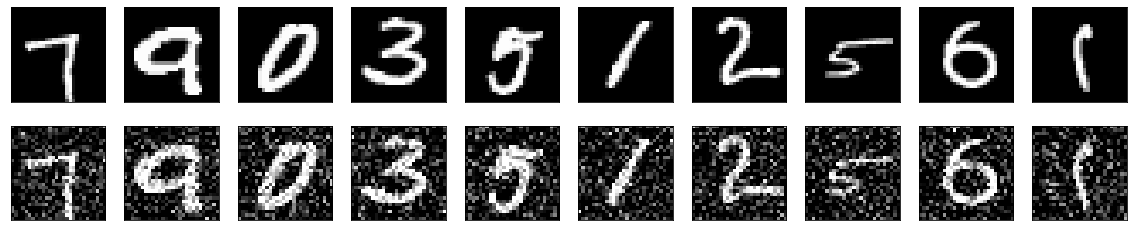

In [18]:
visualise_images(x_train,train_noise)

In [80]:
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(7, (3, 3), activation='sigmoid', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) 
# logits = layers.Dense(10)(x)
# Decoder
x = layers.Conv2D(7, (3, 3), activation='sigmoid', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, x)
autoencoder.summary(expand_nested=True)
#classification head
# logits = layers.Dense(10)(encoded)

# pretrained_classifier = tf.keras.Model(x, logits)
# pretrained_classifier.summary(expand_nested=True)

#classifier
# classifier = Conv2D(16, (3, 3), padding='same', activation='sigmoid')(input_img)
#                                          MaxPooling2D((2, 2), padding='same'),
#                                          Conv2D(2, (3, 3), activation='sigmoid', padding='same'),
#                                          MaxPooling2D((2, 2), padding='same'),
#                                          Flatten(),
#                                          Dense(10)])

# autoencoder = tf.keras.Sequential(name="autoencoder", layers=[encoder, decoder])


# encoder = Sequential(name="encoder", 
#                               layers=[Conv2D(16, (3, 3), padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
#                                          MaxPooling2D((2, 2), padding='same'),
#                                          Conv2D(2, (3, 3), activation='sigmoid', padding='same'),
#                                          MaxPooling2D((2, 2), padding='same'),
#                                       ])
# decoder = Sequential(name="decoder",
#                               layers=[Conv2D(2, (3, 3), padding='same',  activation='sigmoid', input_shape=(7, 7, 2)),
#                                       UpSampling2D((2, 2)),
#                                       Conv2D(16, (3, 3), padding='same',  activation='sigmoid'),
#                                       UpSampling2D((2, 2)),
#                                       layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
#                                       ]) 

# autoencoder = Sequential(name="autoencoder", layers=[encoder, decoder])

# autoencoder.summary(expand_nested=True)

# classification_head = tf.keras.Sequential(name="classification_head", 
#                                           layers=[Flatten(input_shape=(7, 7, 2)),
#                                                    Dense(10)])
# pretrained_classifier = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head])

# classifier = Sequential(name="classifier",
#                                  layers=[Conv2D(16, (3, 3), padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
#                                          MaxPooling2D((2, 2), padding='same'),
#                                          Conv2D(2, (3, 3), activation='sigmoid', padding='same'),
#                                          MaxPooling2D((2, 2), padding='same'),
#                                          Flatten(),
#                                          Dense(10)])

# pretrained_classifier.summary(expand_nested=True)
# classifier.summary(expand_nested=True)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_125 (Conv2D)         (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_126 (Conv2D)         (None, 14, 14, 7)         1015      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 7, 7, 7)          0         
 g2D)                                                            
                                                                 
 conv2d_127 (Conv2D)         (None, 7, 7, 7)           448

In [85]:
x.trainable = False  # Freeze the encoder!

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=0, write_graph=False)])


Epoch 1/50
469/469 [==============================] - 72s 152ms/step - loss: 0.0889 - val_loss: 0.0865
Epoch 2/50
469/469 [==============================] - 67s 142ms/step - loss: 0.0862 - val_loss: 0.0839
Epoch 3/50
317/469 [===================>..........] - ETA: 21s - loss: 0.0843

KeyboardInterrupt: ignored

In [56]:
pretrained_classifier.compile(optimizer='adam', 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier.compile(optimizer='adam', 
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [75]:
pretrained_classifier.fit(train_data, epochs=25)
pretrained_classifier.evaluate(test_data)

Epoch 1/25


TypeError: ignored

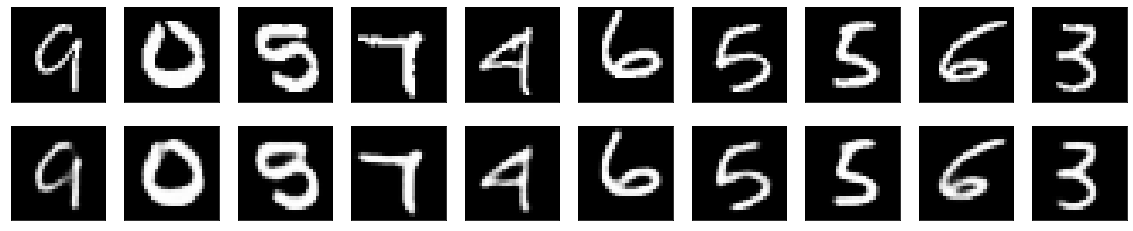

In [35]:
predictions = autoencoder.predict(x_test)
visualise_images(x_test, predictions)

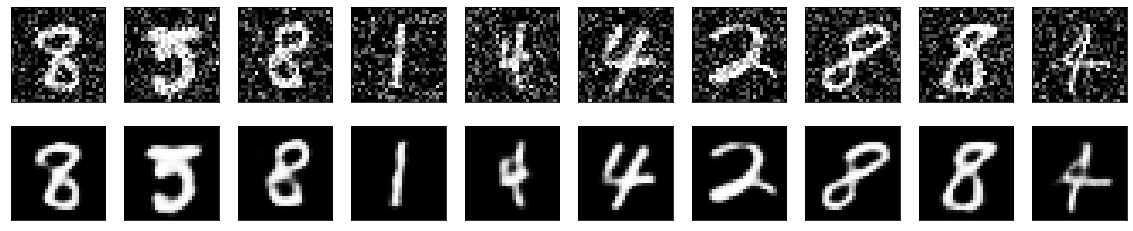

In [36]:
predictions = autoencoder.predict(test_noise)
visualise_images(test_noise, predictions)